<a href="https://colab.research.google.com/github/morenourey/ENTREGABLES/blob/main/transf_learning_catsanddogs_finetuning_data_augmentation_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)

#Transfer Learning con la técnica de Fine Tuning

# Connectar a Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Librerias

In [2]:
from tensorflow import keras as ks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model, load_model

# Variables de entorno

<font color="#FF0000">Aquí definireis vuestra ruta del proyecto de perros y Gatos</font>

In [3]:
ANCHO_IMAGEN = 150
ALTURA_IMAGEN=150
IMAGE_SIZE = (ANCHO_IMAGEN, ALTURA_IMAGEN)
CANALES_IMAGENES = 3

ruta_archivos = '/content/drive/MyDrive/NUCLIO/'

# Cargaremos datos en NPZ


In [4]:
dict_npz = np.load(ruta_archivos+'xy_train_img.npz')
x_train_img = dict_npz['x']
y_train_img = dict_npz['y']

dict_npz = np.load(ruta_archivos+'xy_test_img.npz')
x_test_img = dict_npz['x']
y_test_img = dict_npz['y']

dict_npz = np.load(ruta_archivos+'xy_val_img.npz')
x_val_img = dict_npz['x']
y_val_img = dict_npz['y']

In [5]:
x_train_scaled = x_train_img / 255.
x_test_scaled = x_test_img / 255.
x_val_scaled = x_val_img / 255.

# Montamos la Red Neuronal

## Cargar la parte de extraccion de features de VGG16

In [6]:
vgg = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(ANCHO_IMAGEN, ALTURA_IMAGEN, CANALES_IMAGENES))

58889256/58889256 [==============================] - 0s 0us/step


In [7]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

Como se puede ver en el summary, no tenemos capa Flatten de salida, así que creamos una Flatten basandonos en el output de la red neurona vgg. Y con Model() enganchamos una con la otra.

In [ ]:
output = vgg.layers[-1].output
new_output_layer = ks.layers.Flatten()(output)
vgg_model = Model(vgg.input, new_output_layer)

In [ ]:
vgg_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

Veamos si son entrenables o no dichas capas

In [ ]:
print("Is model trainable?", vgg_model.trainable)

Is model trainable? True


In [ ]:
pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fabe836aad0>,input_1,True
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fabda071690>,block1_conv1,True
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fabd93836d0>,block1_conv2,True
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fabd93c1590>,block1_pool,True
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fabdfe60050>,block2_conv1,True
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fabdfed0f50>,block2_conv2,True
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fabd82ca850>,block2_pool,True
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fabd82e6590>,block3_conv1,True
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fabd0171650>,block3_conv2,True
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fabd017c850>,block3_conv3,True


Vamos a activar como entrenables solo las convoluciones del bloque 4 para abajo, de ahí que hagamos el siguiente bucle.

In [ ]:
entrenable = False

for layer in vgg_model.layers:
  if layer.name == 'block4_conv1':
    entrenable = True
  layer.trainable = entrenable

In [ ]:
pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fabe836aad0>,input_1,False
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fabda071690>,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fabd93836d0>,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fabd93c1590>,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fabdfe60050>,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fabdfed0f50>,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fabd82ca850>,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fabd82e6590>,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fabd0171650>,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fabd017c850>,block3_conv3,False


# Montemos la red de VGG16 + Clasificación


In [ ]:
input_shape = vgg_model.output_shape[1]

print('Tamaño de entrada:', input_shape)

Tamaño de entrada: 8192


In [ ]:
model_with_vgg = ks.Sequential()

model_with_vgg.add(vgg_model)
model_with_vgg.add(ks.layers.Dense(512, activation='relu', input_shape=(input_shape,)))
model_with_vgg.add(ks.layers.Dropout(0.3))
model_with_vgg.add(ks.layers.Dense(512, activation='relu'))
model_with_vgg.add(ks.layers.Dropout(0.3))
model_with_vgg.add(ks.layers.Dense(1, activation='sigmoid'))

model_with_vgg.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 8192)              14714688  
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 19,172,673
Trainable params: 17,437,185
Non-trainable params: 1,735,488
____________________________________

# Creamos un optimizador

Como la red es muy compleja (más de 17 millones de parámetros), necesitamos un learning rate muy bajo, por eso creamos un Adam específico con un learning rate de 0.00002 (2e-5)

In [ ]:
from tensorflow.keras.optimizers import Adam, SGD

In [ ]:
new_adam = Adam(learning_rate=2e-5)
new_sgd = SGD(learning_rate=2e-5, momentum=0.9)


In [ ]:
model_with_vgg.compile(loss='binary_crossentropy', optimizer=new_sgd, metrics=['accuracy'])

# Early stopping!!
Montamos la monitorización del error de validación con paciencia de 5

In [ ]:
earlystop = EarlyStopping(monitor='val_loss', patience=20)

# Model Checkpoint
Montamos la monitorización para ir guardando el mejor modelo del entrenamiento con mejor accuracy de validacion

In [ ]:
modelcheckpoint = ModelCheckpoint('/tmp/chkpoint', monitor='val_accuracy', save_best_only=True)

# Preprocesamos las etiquetas con el LabelEncoder

Hay que recordar que las etiquetas han de tener el formato [value1, value2, ... valueN] porque el ImageDataGenerator no sabe que hacer si las etiquetas son [[value1], [value2],... [valueN]]

¡En ese caso hay que hacer un .ravel() al array!

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y_train_img)
y_train_encoded = le.transform(y_train_img)
y_val_encoded = le.transform(y_val_img)
y_test_encoded = le.transform(y_test_img)

In [ ]:
print(np.array(y_train_img))
print(np.array(y_train_encoded))

y_train_encoded

['cat' 'cat' 'cat' ... 'dog' 'dog' 'dog']
[0 0 0 ... 1 1 1]


array([0, 0, 0, ..., 1, 1, 1])

## Data Augmentation

Como la red es muy compleja hemos de ir con cuidado con el batch_size de los generadores de imagenes, que no superen los 32 elementos

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest'
    )

train_generator = train_datagen.flow(
    x_train_img,
    y_train_encoded,
    batch_size=30
)

In [ ]:
validation_datagen = ImageDataGenerator(
    rescale=1./255
    )
validation_generator = validation_datagen.flow(
    x_val_img,
    y_val_encoded,
    batch_size=20
)


# Entrenar

Al montar el data augmentation los steps per epochs y los validation steps hay que definirlos:

steps_per_epochs = total imagenes / batch_size del train generator = 5000 / 30 = 167<br>
validation_steps = total imagenes validacion / batch_size del validation generator = 1000 / 20 = 50

In [ ]:
history = model_with_vgg.fit(train_generator, epochs=200, steps_per_epoch=167,
                             callbacks=[modelcheckpoint, earlystop],
                             validation_data=validation_generator, validation_steps=50)

Epoch 1/200
167/167 [==============================] - 71s 213ms/step - loss: 0.7280 - accuracy: 0.5028 - val_loss: 0.6754 - val_accuracy: 0.5730
INFO:tensorflow:Assets written to: /tmp/chkpoint/assets
Epoch 2/200
167/167 [==============================] - 34s 202ms/step - loss: 0.7028 - accuracy: 0.5292 - val_loss: 0.6337 - val_accuracy: 0.7190
INFO:tensorflow:Assets written to: /tmp/chkpoint/assets
Epoch 3/200
167/167 [==============================] - 34s 203ms/step - loss: 0.6742 - accuracy: 0.5728 - val_loss: 0.5922 - val_accuracy: 0.7910
INFO:tensorflow:Assets written to: /tmp/chkpoint/assets
Epoch 4/200
167/167 [==============================] - 34s 201ms/step - loss: 0.6368 - accuracy: 0.6382 - val_loss: 0.5429 - val_accuracy: 0.8200
INFO:tensorflow:Assets written to: /tmp/chkpoint/assets
Epoch 5/200
167/167 [==============================] - 35s 207ms/step - loss: 0.6098 - accuracy: 0.6710 - val_loss: 0.4914 - val_accuracy: 0.8260
INFO:tensorflow:Assets written to: /tmp/chkpoi

# Recuperamos el mejor modelo del checkpoint y lo guardamos


In [ ]:
model_with_vgg.load_weights('/tmp/chkpoint')

In [ ]:
model_with_vgg.save(ruta_archivos+"model_with_finetunning_transfer_learning_vgg16_plus_data_augmentation.h5")

# Carguemos el modelo con  Transfer Learning sin data augmentation

Aquí recogeremos el modelo y los datos de XY pasados por VGG16 post procesados guardados en NPZ

In [ ]:
model_vgg16_fine_tuning = load_model(ruta_archivos+"model_with_finetunning_transfer_learning_vgg16.h5")


# Miremos que tal rinde el modelo en errores y accuracy

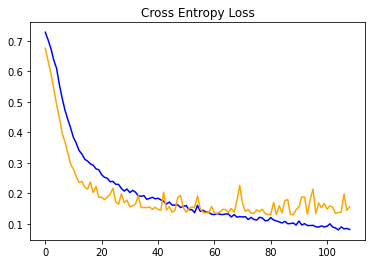

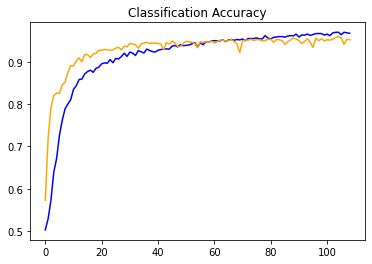

In [ ]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test')
plt.show()

In [ ]:
_, acc = model_with_vgg.evaluate(x_test_scaled, y_test_encoded, verbose=0)
print('Modelo con Fine Tunning Transfer Learning con Data Augmentation> %.3f' % (acc * 100.0))

_, acc = model_vgg16_fine_tuning.evaluate(x_test_scaled, y_test_encoded, verbose=0)
print('Modelo con Fine Tuning Transfer Learning sin Data Augmentaion> %.3f' % (acc * 100.0))

Modelo con Fine Tunning Transfer Learning con Data Augmentation> 95.800
Modelo con Fine Tuning Transfer Learning sin Data Augmentaion> 95.600
